---
title: "Text Analysis and NLP Project:Emotion Detection from Text"
author:
  - Nastaran Mesgari

date: 2024-05-19

abstract: ""

format: 
  html:  
    code-fold: true
    standalone: true
    embed-resources: true
    number-sections: true # numbering the header
    toc: true
    toc-depth: 4
---

## Executive Summary


# Introduction
Emotion detection from text is one of the challenging problems in Natural Language Processing. The reason is the unavailability of labeled dataset and the multi-class nature of the problem. Humans have a variety of emotions, and it is difficult to collect enough records for each emotion and hence the problem of class imbalance arises. Here we have labeled data for emotion detection and the objective is to build an efficient model to detect emotion.

### importing libraries

In [201]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
# nltk.download('stopwords')
import pickle
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.naive_bayes import MultinomialNB

import keras
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau 

from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, average_precision_score, recall_score, precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [202]:
# Reading the data
df = pd.read_csv('Data/text_emotion.csv')
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


### Data Exploration

In [203]:
# Information of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [204]:
# Unique values from 'sentiment'
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [205]:
# Frequency distribution of'sentiment'
frequency_counts = df['sentiment'].value_counts()

frequency_percentage = (frequency_counts / len(df['sentiment'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Print total value
cardinality = df['sentiment'].nunique()
print(f"\ntotal values: {cardinality}")

            Counts  Percentage
sentiment                     
neutral       8638     21.5950
worry         8459     21.1475
happiness     5209     13.0225
sadness       5165     12.9125
love          3842      9.6050
surprise      2187      5.4675
fun           1776      4.4400
relief        1526      3.8150
hate          1323      3.3075
empty          827      2.0675
enthusiasm     759      1.8975
boredom        179      0.4475
anger          110      0.2750

total values: 13


Regarding the below countplot based on the sentiment, it can be seen than the dataset is imbalanced.and tweet are more about negative and neutral .

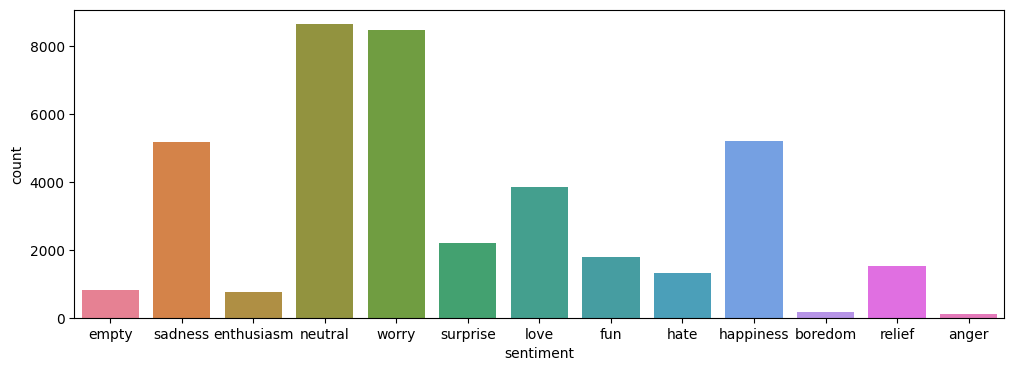

In [206]:
plt.figure(figsize=(12,4));
sns.countplot(x='sentiment', data=df, palette='husl');

for balancing the data I selected 3 groups , Posetive , Negative and Neutral.Surprise sentiment was selected as a neutral because it is not be shown:  is it posetive or negative and when I do that the prevalence ≤ 10% and it is considered for imbalancing data.


In [207]:
#  grouping 13 labels into 3 classes: 'negative', 'positive', 'neutral'
sentiment_mapping = {
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive'
}

# Create a new col for the mapping
df['label'] = df['sentiment'].map(sentiment_mapping)

In addition,I check out the average lendth of the Comments are approximately 73.5 words.

In [208]:
# Size of the texts
total_length = 0
num_texts = len(df['content'])
for text in df['content']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 73.40555


# Text Pre-processing
The text pre-processing is a very critical step because better results can only be achieved with good quality of data. Since the tweets texts are unstructured or in other words, they are raw and very noisy, they require cleaning. The main objective of this step is to remove noisy and inconsistent texts. Comments that carry very little weighting in text context, for example numbers, special character, punctuations, hashtags, extra blank space, etc. need to be removed. The following steps are taken for the text cleaning.

### Removing special characters and lowercasing
Unstructured texts such as Comments may contain numbers, special characters, punctuations, hashtags, extra blank space, etc. We need to remove them from the texts. Therefore, I This function performs the following steps:

**removing any word which starts with @.**

**removing all non-alphabetic characters in the string with spaces.**

**changing all the letters into lower case.**

**replacing more than one space with one space and removing any leading and trailing space.**

**iltering out any punctuation marks from the text.**

### Tokenization
Tokenization involves dividing a text or document into smaller elements known as tokens, aiming to transform continuous text into distinct units for computer processing. It's an essential process in natural language processing and text analysis, facilitating various algorithms and methods that rely on tokenized data. In my approach, I utilized the wordpunct_tokenize() function from NLTK library, which efficiently separates text into individual tokens or words by identifying non-alphanumeric characters like punctuation marks or special symbols.

### Removing Numbers
Eliminating numbers from text during text analysis can be crucial, especially considering the context and objectives of the analysis. Given that the project involves comments and tweets, with a focus on language patterns, numbers might not contribute significantly to the analysis. Thus, excluding numbers can enhance the consistency of the text. Following tokenization, I filtered out any tokens identified as digits.

### Removing stop-words
Stop words, such as "the", "a", "an", "and", "but", "in", "on", etc., are highly common in language and typically add little substantive meaning. Conversely, non-stop words, encompassing nouns, verbs, adjectives, adverbs, and other significant parts of speech, carry more weight in conveying meaning. In text analysis, filtering out stop words can enhance the relevance and clarity of the analysis. To achieve this, I compared each word in the Comments texts with NLTK's pre-defined English stop words list, retaining only the non-stop words for further analysis.

### English Language detection
Ensuring that the texts are in English is vital for achieving accurate and effective text analysis. Since numerous NLP techniques and tools are tailored to specific languages, particularly English, analyzing English text enables the utilization of language-specific resources and models. To accomplish this, I implemented a filter on the tokenized texts, verifying whether each token belongs to the set of English words sourced from the nltk.corpus.words module.


###  lemmatizing the words
Lemmatization simplifies words to their base or root form, known as the "lemma," aiming to unify inflectional and sometimes derivational variations of a word. This process reduces the total number of unique words in a text, aiding in text analysis by standardizing vocabulary and mitigating data sparsity. For this project, I employed NLTK's WordNetLemmatizer as the lemmatization tool, which utilizes morphological analysis and part-of-speech tagging to identify the base form of a word. Considering the part-of-speech is crucial, as the lemma may vary based on whether the word functions as a noun, verb, adjective, or adverb.


### Cleaning the Dataset 

In [258]:
dfcopy = df.copy()

In [260]:
# Find any numerical variables.
numerical = [var for var in dfcopy.columns if dfcopy[var].dtype!='O']

print('Num of numerical variables: {}\n'.format(len(numerical)))
print('The numerical variables are: ', numerical)

Num of numerical variables: 1

The numerical variables are:  ['tweet_id']


In [261]:
# Drop the unecessary column (numerical variables)
dfcopy= dfcopy.drop(columns=['tweet_id'])

in this step we remove the duplicate rows, it be showned 13 rows.

In [262]:
# Count duplicates
duplicates_count = dfcopy.duplicated().sum()
print(f'Total duplicated rows: {duplicates_count}')

Total duplicated rows: 13


In [263]:
# Check for duplicates
dfcopy[dfcopy['content'].duplicated() == True]

,sentiment,author,content,label
366,worry,jmil1733,I feel so deflated. No more doggy.,negative
521,worry,Chassidy7,Somebody please save the polar bears!,negative
1026,neutral,benmfowler,I'm at work,neutral
3684,sadness,nnurse,@dublins98dave me too! I am down 400 euro,negative
4363,worry,becca4656,"is upset, I left my phone at home again",negative
...,...,...,...,...
39859,love,Miamarie33,Happy Mothers Day,positive
39898,love,xoxodominique,happy mothers day!,positive
39913,happiness,wailanik,happy mother's day!,positive
39915,love,ennahdii,happy mother's day everyone,positive


in this step I reindex the data set

In [264]:
# Drop duplicated values
index = dfcopy[dfcopy['content'].duplicated() == True].index
dfcopy.drop(index, axis = 0, inplace = True)
dfcopy.reset_index(inplace=True, drop = True)

after remove the duplicate rows we have 39827 rows with three columns

In [265]:
# Final shape of data after dropping duplicates
dfcopy.shape
#dfcopy.info

(39827, 4)

In [217]:
# Drop the original column, 'sentiment'
#dfcopy = dfcopy.drop(columns=['sentiment'])

In [266]:
# Calculate the frequency distribution of 'sentiment'
frequency_counts = dfcopy['label'].value_counts()

frequency_percentage = (frequency_counts / len(df['label'])) * 100
frequency_df = pd.DataFrame({'Counts': frequency_counts, 'Percentage': frequency_percentage})

print(frequency_df)

# Total value count
cardinality = df['label'].nunique()
print(f"\ntotal values: {cardinality}")

          Counts  Percentage
label                       
negative   16024     40.0600
positive   13024     32.5600
neutral    10779     26.9475

total values: 3


In [267]:
# Final check - Extract unique values from 'sentiment'
unique_sentiments = dfcopy['label'].unique()
print(unique_sentiments)

['negative' 'positive' 'neutral']


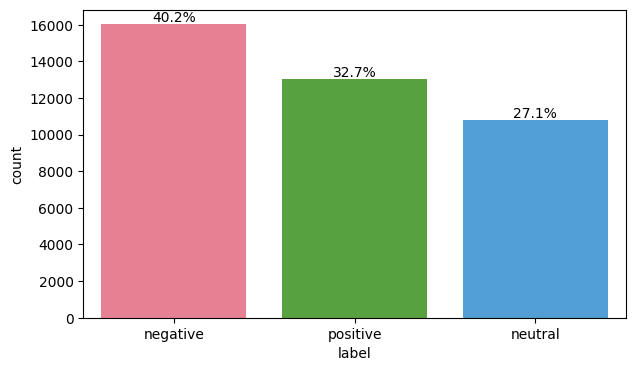

In [268]:


# Your DataFrame and countplot code
plt.figure(figsize=(7,4))
ax = sns.countplot(x='label', data=dfcopy, palette='husl')

# Calculate total number of data points
total = len(dfcopy['label'])

# Annotate each bar with its percentage
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()




In [269]:
# Mapping sentiment num / encode
dfcopy["label_num"] = dfcopy.label.map({
    'negative': 0,
    'positive': 1,
    'neutral': 2
})

dfcopy = dfcopy.drop(columns=['label'])
dfcopy.head(5)

,sentiment,author,content,label_num
0,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,0
1,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,0
2,sadness,coolfunky,Funeral ceremony...gloomy friday...,0
3,enthusiasm,czareaquino,wants to hang out with friends SOON!,1
4,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,2


In [270]:
X = dfcopy['content']
y = dfcopy['label_num']

# Making sure that X y have the same length
print(len(X))
print(len(y))

39827
39827


In [271]:
dfcopy.columns

Index(['sentiment', 'author', 'content', 'label_num'], dtype='object')

In [272]:
# Deviding the dataset into 10 parts
part_1 = dfcopy.iloc[0:20000,:]
part_2 = dfcopy.iloc[20000:39827,:]
print(part_1)

        sentiment       author  \
0           empty   xoshayzers   
1         sadness    wannamama   
2         sadness    coolfunky   
3      enthusiasm  czareaquino   
4         neutral    xkilljoyx   
...           ...          ...   
19995       worry       AP2005   
19996        love   rissastory   
19997     neutral    kridrules   
19998   happiness       isabuu   
19999   happiness    gAllethOo   

                                                 content  label_num  
0      @tiffanylue i know  i was listenin to bad habi...          0  
1      Layin n bed with a headache  ughhhh...waitin o...          0  
2                    Funeral ceremony...gloomy friday...          0  
3                   wants to hang out with friends SOON!          1  
4      @dannycastillo We want to trade with someone w...          2  
...                                                  ...        ...  
19995  I just want this semester to be over! Only a w...          0  
19996  listening to i can't wai

In [273]:
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    pos_tags = pos_tag(tokens)
    wn_pos_tags = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    
    # Lemmatize each word based on its POS tag
    lemmas = []
    for token, pos in pos_tags:
        pos = wn_pos_tags.get(pos[0].upper(), 'n')  # If the POS tag is not recognized, default to noun (n)
        lemma = lemmatizer.lemmatize(token, pos=pos)
        lemmas.append(lemma)
    return lemmas

In [274]:
# Text Processing in a single code
#import nltk
#nltk.download('words')

words = set(nltk.corpus.words.words())
def text_cleaner(contents):
    contents = " ".join(filter(lambda x: x[0]!= '@' , contents.split())) # removes any word which starts with @.
    contents = re.sub('[^0-9a-zA-Z]', ' ', contents) # substitute all non-alphabetic characters in the string with spaces.
    contents = contents.lower() # lowercasing
    contents = re.sub(' +', ' ', contents).strip() # replacing more than one space with 1 space and remove any leading and trailing space.
    contents = nltk.wordpunct_tokenize(contents)
    contents = [word for word in contents if not word.isdigit()]
    contents = [word for word in contents if word.lower() in words or not word.isalpha()]
    contents = [word for word in contents if not word in set(stopwords.words('english'))] # Keeping only the non-stop words in the string
    contents = lemmatize(contents)
    contents = " ".join(contents)
    return contents

In [275]:
part_1.loc[:, 'clean_content'] = part_1['content'].apply(text_cleaner)


C:\Users\Nastaran\AppData\Local\Temp\ipykernel_10944\3514124814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_1.loc[:, 'clean_content'] = part_1['content'].apply(text_cleaner)


In [229]:
part_2.loc[:, 'clean_content'] = part_2['content'].apply(text_cleaner)


C:\Users\Nastaran\AppData\Local\Temp\ipykernel_10944\385989757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_2.loc[:, 'clean_content'] = part_2['content'].apply(text_cleaner)


In [230]:
cleandf = pd.concat([part_1, part_2])


In [231]:
cleandf.info

<bound method DataFrame.info of               author                                            content  \
0         xoshayzers  @tiffanylue i know  i was listenin to bad habi...   
1          wannamama  Layin n bed with a headache  ughhhh...waitin o...   
2          coolfunky                Funeral ceremony...gloomy friday...   
3        czareaquino               wants to hang out with friends SOON!   
4          xkilljoyx  @dannycastillo We want to trade with someone w...   
...              ...                                                ...   
39822  showMe_Heaven                                   @JohnLloydTaylor   
39823       drapeaux                     Happy Mothers Day  All my love   
39824       JenniRox  Happy Mother's Day to all the mommies out ther...   
39825       ipdaman1  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...   
39826    Alpharalpha  @mopedronin bullet train from tokyo    the gf ...   

       label_num                                     clean_content 

In [277]:
tokenized_text = []
for i in cleandf['clean_content']:
    x =  word_tokenize(i)
    tokenized_text.append(x)
cleandf['tokenized'] = tokenized_text

### Investigating Stopwords in Text

In [278]:
# Count stopwords present in the data
#nltk.download('punkt')
def count_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(text)
    return len(set(words) & stop_words)

# Add a new col 'stop_words' that contains the count of stopwords
cleandf['stop_words'] = cleandf['content'].apply(count_stopwords)
value_counts = cleandf['stop_words'].value_counts()

In [279]:
# Count the number of stopwords in the data
temp = cleandf.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & stop_words))

# Print rows that contain stopwords
rows_with_stopwords = temp[temp['stop_words'] > 0]
print(rows_with_stopwords)

                                                 content  label_num  \
0      @tiffanylue i know  i was listenin to bad habi...          0   
1      Layin n bed with a headache  ughhhh...waitin o...          0   
3                   wants to hang out with friends SOON!          1   
4      @dannycastillo We want to trade with someone w...          2   
5      Re-pinging @ghostridah14: why didn't you go to...          0   
...                                                  ...        ...   
39819  @jasimmo Ooo showing of your French skills!! l...          2   
39820  @sendsome2me haha, yeah. Twitter has many uses...          2   
39823                     Happy Mothers Day  All my love          1   
39824  Happy Mother's Day to all the mommies out ther...          1   
39826  @mopedronin bullet train from tokyo    the gf ...          1   

                                     clean_content  \
0                              know bad habit part   
1                              n bed he

In [280]:
# Explore tweet that contains stopwords
cleandf['content'][10]
cleandf.loc[10]

content                     cant fall asleep
label_num                                  2
clean_content               cant fall asleep
tokenized               [cant, fall, asleep]
content_length                            16
tokenized_length                           3
clean_content_length                      16
stop_words                                 0
Name: 10, dtype: object

In [281]:
# Count stopwords in index 10
stop_words = set(stopwords.words("english"))
cleandf_indx = cleandf['content'][10]
stopword_count = len([word for word in cleandf_indx.split() if word in stop_words])
stopword_count

0

In [282]:
# Print all the stopwords in index 10
stopwords_in_content = [word for word in cleandf_indx.split() if word in stop_words]

print("Stopwords in df['content'][10]:")
print(stopwords_in_content)


Stopwords in df['content'][10]:
[]


## Data Cleaning
<p style="text-align: justify;">
After text pre-processing, I removed these NaN or duplicate values from dataset. The shape of the dataset reduces into 39827.
</p>

In [283]:
print('The number of NaN-values in the pre-processed dataset is: ', dfcopy['content'].isnull().sum())


The number of NaN-values in the pre-processed dataset is:  0


In [284]:
dfcopy.loc[df['content'].isnull()].head

<bound method NDFrame.head of Empty DataFrame
Columns: [sentiment, author, content, label_num]
Index: []>

In [285]:
cleandf.shape
cleandf.columns


Index(['content', 'label_num', 'clean_content', 'tokenized', 'content_length',
       'tokenized_length', 'clean_content_length', 'stop_words'],
      dtype='object')

In [287]:
# Drop the unecessary column 
cleandf= cleandf.drop(columns=[ 'stop_words', ])

In [288]:
#| include: False
cleandf.dropna(axis = 0, inplace = True)
cleandf.shape

(39827, 7)

In [289]:
cleandf.loc[cleandf['clean_content'].isnull()].head()

,content,label_num,clean_content,tokenized,content_length,tokenized_length,clean_content_length


# Data Visualisation
###  Comparing the text length with boxplot and histogram
In this phase of the project, I examined comment lengths across different label categories by introducing the `content_length` variable to the dataset. Upon analyzing the statistical information of this column, it became apparent that some comments exceed 120 words, although their frequency is relatively low compared to the dataset size. To enhance visualization clarity in the box plot and histogram representations of the `content_length` variable, I opted to filter out comments containing more than 120 words. However, despite this preprocessing step, neither the box plot nor the histogram revealed any significant differences among the label categories.

In [290]:
cleandf['content_length'] = cleandf['content'].str.len()
cleandf['tokenized_length'] = cleandf['tokenized'].str.len()
cleandf['clean_content_length'] = cleandf['clean_content'].str.len()
cleandf.head()

,content,label_num,clean_content,tokenized,content_length,tokenized_length,clean_content_length
0,@tiffanylue i know i was listenin to bad habi...,0,know bad habit part,"[know, bad, habit, part]",92,4,19
1,Layin n bed with a headache ughhhh...waitin o...,0,n bed headache call,"[n, bed, headache, call]",60,4,19
2,Funeral ceremony...gloomy friday...,0,funeral ceremony gloomy,"[funeral, ceremony, gloomy]",35,3,23
3,wants to hang out with friends SOON!,1,soon,[soon],36,1,4
4,@dannycastillo We want to trade with someone w...,2,want trade someone one,"[want, trade, someone, one]",86,4,22


In [291]:
cleandf.shape

(39827, 7)

In [292]:
cleandf['clean_content_length'].describe()

count    39827.000000
mean        28.827002
std         18.339489
min          0.000000
25%         14.000000
50%         26.000000
75%         41.000000
max        108.000000
Name: clean_content_length, dtype: float64

In [293]:
# Size of the clean_content
total_length = 0
num_texts = len(cleandf['clean_content'])
for text in cleandf['clean_content']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 28.827001782710223


In [294]:
# Size of the content
total_length = 0
num_texts = len(cleandf['content'])
for text in cleandf['content']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 73.53082079995983


In [295]:
# Size of the tokenized
total_length = 0
num_texts = len(cleandf['tokenized'])
for text in cleandf['tokenized']:
    total_length += len(text)

avg_length = total_length / num_texts

print(f"The average length of the texts is {avg_length}")

The average length of the texts is 5.262409922916614


In [296]:
cleandf[cleandf['clean_content_length']>28].shape

(17976, 7)

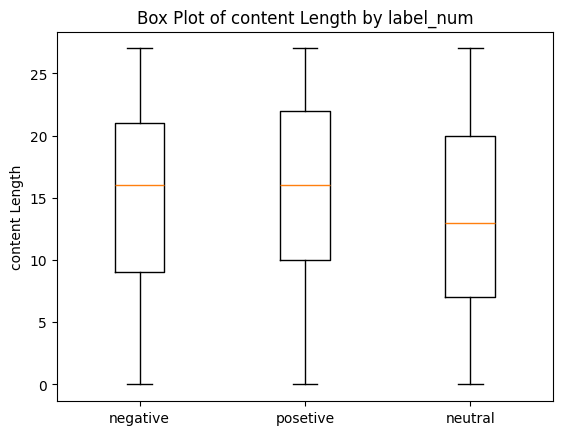

In [297]:
# Boxplots of text lenghth
plt.figsize = (9,3)
filtered_content = cleandf[cleandf['clean_content_length'] < 28]

negative_lengths = filtered_content[filtered_content['label_num'] == 0]['clean_content_length']
posetive_lengths = filtered_content[filtered_content['label_num'] == 1]['clean_content_length']
neutral_lengths = filtered_content[filtered_content['label_num'] == 2]['clean_content_length']
plt.boxplot([negative_lengths, posetive_lengths ,neutral_lengths], labels=['negative', 'posetive','neutral'])
plt.ylabel('content Length')
plt.title('Box Plot of content Length by label_num')
plt.show()



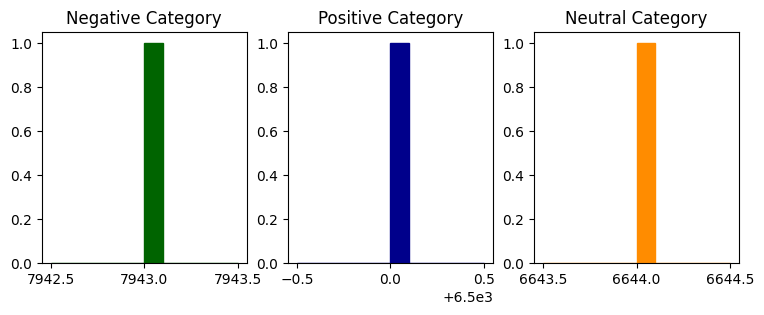

In [301]:

# Histogram

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

txtlen_negative = filtered_content[filtered_content['label_num'] == 0]['clean_content'].size
ax1.hist(txtlen_negative, color='darkgreen', edgecolor='darkgreen')
ax1.set_title('Negative Category')

txtlen_positive = filtered_content[filtered_content['label_num'] == 1]['clean_content'].size
ax2.hist(txtlen_positive, color='darkblue', edgecolor='darkblue')
ax2.set_title('Positive Category')

txtlen_neutral = filtered_content[filtered_content['label_num'] == 2]['clean_content'].size
ax3.hist(txtlen_neutral, color='darkorange', edgecolor='darkorange')
ax3.set_title('Neutral Category')

plt.show()


### Word Cloud
<p style="text-align: justify;">
The word clouds for each label category (positive, negative, neutral) visually showcase the most prevalent words within their respective comments. Utilizing varying font sizes, the word clouds emphasize the frequency of each word, enabling quick recognition of prominent patterns or trends. Interestingly, negative comments exhibit recurrent words like "even" and "also," indicating prevalent sentiments, while positive comments lack similarly prominent terms, suggesting a more diverse vocabulary in expressing positivity.
</p>

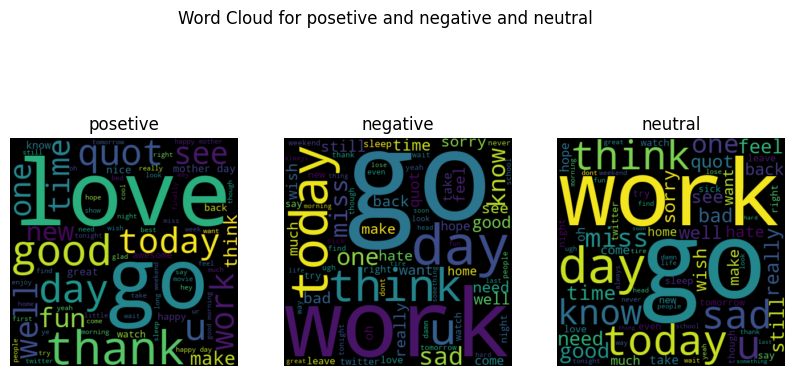

In [302]:
# Word Cloud


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))

posetive_text = ' '.join(cleandf[cleandf['label_num']==1]['clean_content'])
wordcloud_posetive = WordCloud(max_words=73, width=400, height=400).generate(posetive_text)

negative_text = ' '.join(cleandf[cleandf['label_num']==0]['clean_content'])
wordcloud_negative = WordCloud(max_words=73, width=400, height=400).generate(negative_text)

neutral_text = ' '.join(cleandf[cleandf['label_num']==0]['clean_content'])
wordcloud_neutral = WordCloud(max_words=73, width=400, height=400).generate(neutral_text)

ax1.imshow(wordcloud_posetive, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('posetive')

ax2.imshow(wordcloud_negative, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('negative')

ax3.imshow(wordcloud_neutral, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('neutral')
plt.suptitle('Word Cloud for posetive and negative and neutral');

## Dropping the unnessecary columns
<p style="text-align: justify;">
The objective of this project is to train a classification model on the comments text and the sentiment label. So other columns ('content', 'clean_content', 'content_length',
       'tokenized_length', 'clean_content_length') are removed from the dataset and it would be ready for nexts steps.
</p>

In [303]:
cleandf.columns

Index(['content', 'label_num', 'clean_content', 'tokenized', 'content_length',
       'tokenized_length', 'clean_content_length'],
      dtype='object')

In [304]:
# Removing unnecessary columns
cleandf.drop(['content', 'clean_content', 'content_length','tokenized_length', 'clean_content_length'],axis = 1, inplace = True)

In [305]:
#| include: False
cleandf.head()

,label_num,tokenized
0,0,"[know, bad, habit, part]"
1,0,"[n, bed, headache, call]"
2,0,"[funeral, ceremony, gloomy]"
3,1,[soon]
4,2,"[want, trade, someone, one]"


### Training the Word2vec Model
<p style="text-align: justify;">
Text data is in the form of strings, but machine learning models work with numerical data. Therefore, The text must be converted text to numbers. In order to transfer the texts, I used the Word2Vec technique.
Word2Vec is a neural network-based technique for converting text to numerical vectors. It represents each word in the text as a high-dimensional vector, where words that appear in similar contexts have similar vectors. Word2Vec can capture the semantic and syntactic relationships between words in a text, and this makes it a powerful technique for natural language processing (NLP) tasks such as text classification. 
</p>

In used the following hyperparameters for my word2vec model.

* vector_size = 100: The vector_size parameter refers to the size of the embedding vector that is learned for each word in the vocabulary. This parameter determines the number of dimensions in the continuous vector space used to represent words. For example, if size_dim=100, each word in the vocabulary will be represented as a vector of 100 floating point values.
* window = 4: The window parameter specifies the maximum distance between the current word and the predicted word within a sentence. In other words, it determines the size of the window of words that the algorithm considers when predicting the next word in a sentence.
* min_count = 10: This parameter specifies the minimum count of a word that is needed to be included in the vocabulary. The words that occur less than min_count times in the corpus are ignored and not included in the model training process. This parameter is used to filter out rare words, which may not be useful for training a model, and may introduce noise in the final embeddings.
* sg = 1: In Word2Vec model, sg stands for "skip-gram". It is one of the two algorithms used in Word2Vec, the other being "continuous bag of words (CBOW)". The skip-gram model predicts the context words (surrounding words) given a target word, whereas the CBOW model predicts the target word given the context words. The skip-gram model is known to work well with large datasets and rare words, while the CBOW model is faster and works better for frequent words. In Gensim's Word2Vec class, sg=0 corresponds to CBOW, and sg=1 corresponds to Skip-gram. 

<p style="text-align: justify;">
After defining the model and selecting the hyperparameters, I trained it using all the texts in the dataset and then transformed my comments dataset into numeric vectors.
</p>


In [351]:
# code-fold: true
# Train the Word2Vec Model

vector_size = 100 
window = 4 
min_count = 10 
sg = 1
text_processed = pd.Series(cleandf['tokenized']).values

w2v_model = Word2Vec(text_processed, vector_size= vector_size , min_count = min_count, window = window, sg = sg)

### Transforming texts into numerical vector
<p style="text-align: justify;">
After trainig the word2vec model using all the comments, the dataset was transformed into vectors.
First, the dataset was splited into train and test datasets and  20% of the dataset was kept for testing the model. For each of train and test datasets, I created a new file and stored the word vectors. 
Then, the average word vector for each of tokenized text was computed. For each iteration (which is equal to the number of the rows), I took the "tokenized" text and filtered out any tokens that were not in the vocabulary of the pre-trained Word2Vec model (w2v_model) using a list comprehension. Then I took the mean of the word vectors for the remaining tokens along the rows, resulting in a single vector of length 100 and I converted the resulting NumPy array to a list. If the result was not a list, which means that there were no tokens in the row that were in the vocabulary of the Word2Vec model, then a line of zeros is written to the file instead.
Then I wrote the header row to the CSV file. The header row contains the numbers 0 through 99, which correspond to the indices of the elements in each word vector.
</p>

In [307]:
training, testing = train_test_split(cleandf, test_size=0.2, random_state = 15)
print('Train Dataset shape: ',training.shape)
print('Test Dataset shape: ',testing.shape)

Train Dataset shape:  (31861, 2)
Test Dataset shape:  (7966, 2)


In [308]:
word2vec_test = r'word2vec_test.csv'

with open(word2vec_test, 'w+') as word2vec_file:
    for index, row in testing[['tokenized', 'label_num']].iterrows():
        # Taking average of vectors in a sentence. This will create an average array that captures the sentiment of the sentence
        model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
        if word2vec_file.tell() == 0:
            header = "label_num," + ",".join(str(item) for item in range(100))
            word2vec_file.write(header)
            word2vec_file.write("\n")
            
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join([str(row['label_num'])] + [str(vector_element) for vector_element in model_vector])
        else:
            line1 = ",".join([str(row['label_num'])] + [str(0) for i in range(100)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')


C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [309]:
word2vec_train = r'word2vec_train.csv'

with open(word2vec_train, 'w+') as word2vec_file:
    for index, row in training[['tokenized', 'label_num']].iterrows():
        # Taking average of vectors in a sentence. This will create an average array that captures the sentiment of the sentence
        model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
        if word2vec_file.tell() == 0:
            header = "label_num," + ",".join(str(item) for item in range(100))
            word2vec_file.write(header)
            word2vec_file.write("\n")
            
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join([str(row['label_num'])] + [str(vector_element) for vector_element in model_vector])
        else:
            line1 = ",".join([str(row['label_num'])] + [str(0) for i in range(100)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [352]:
word2vectest= pd.read_csv('word2vec_test.csv')
word2vectrain = pd.read_csv('word2vec_train.csv')
word2vectrain.head()

,label_num,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,-0.029661,0.116194,-0.015958,-0.036240,0.062973,-0.214918,-0.026812,0.383451,-0.224845,...,0.167502,0.143607,0.051287,0.001971,0.237483,0.056968,0.008562,-0.190817,0.018585,-0.040195
1,2,-0.019124,-0.047985,-0.193381,-0.175268,0.202902,-0.242197,-0.054902,0.467169,-0.205615,...,0.140185,0.349242,0.346568,-0.097577,0.241006,0.017593,-0.093735,-0.146588,0.113735,-0.274187
2,0,0.040710,0.228224,-0.094886,0.100622,0.009817,-0.190076,0.208269,0.384254,-0.287756,...,0.334536,0.289468,-0.092252,-0.016789,0.381744,-0.042081,-0.017464,-0.276235,0.057139,0.190358
3,1,-0.011716,0.115574,-0.004336,-0.024436,0.060093,-0.202999,-0.046890,0.351626,-0.208354,...,0.135247,0.151924,-0.023560,-0.016963,0.243830,0.031647,0.000520,-0.213539,-0.019853,0.010887
4,1,-0.004554,0.040148,-0.095781,-0.126745,0.055913,-0.308386,-0.020391,0.453742,-0.137050,...,0.303341,0.174747,0.196588,0.113191,0.190035,0.084859,0.072408,-0.160215,0.034325,-0.095075



## Training the Classification Model
<p style = "text-align: justify;">
In previous steps, the text dataset was cleaned and transformed into numerical vectors and now it can be used as the input of the classification algorithms. The <b>gender</b> column is the label. In this part of the project, different classification algorithms such as <b>Logidtics Regression, Linear Discriminant Analysis (LDA), Decision Tree, K-Nearest Neighbor, Random Forest Classifier</b> and <b> GaussianNB</b> were trained on the training dataset and their performance were evaluated on the testing dataset. 
</p>

<p style="text-align: justify;">
In addition, LSTM model was used for classification. LSTM stands for Long Short-Term Memory, and it is a type of artificial neural network architecture that is commonly used in natural language processing (NLP), speech recognition, and other sequence modeling tasks. I used the Keras library to define my LSTM model. The model has an LSTM layer with 100 neurons, followed by a dense output layer with two neurons (one for each class). As the input vectors have shape (100,) (i.e., 100 features), I reshaped them to have shape (100, 1) to match the input shape of the LSTM layer. The labels are binary (0 or 1), so I used the sparse_categorical_crossentropy loss function and the softmax activation function in the output layer. I trained the model on the training data and used the testing data as validation set during training. After training, I evaluated the model on the test dataset.
</p>

<p style="text-align: justify;">
Based on the presented classification measures, it can be said that the Random Forest Classifier (RFC), which had the highest accuracy, precision, and F1 score, performed the best. Hpwever, with most models scoring at or below 0.56 accuracy, the classifiers' overall performance on this dataset isn't very good. A number of factors, including the complexity and variety of the blog texts and the constraints of the selected categorization algorithms, may have contributed to the low result. 
</p>

| Model    | LSTM | LR   | LDA  | KNN  | DTC  | RFC  | NB   |
| -------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| Accuracy | 0.50 | 0.56 | 0.56 | 0.55 | 0.54 | 0.58 | 0.53 |
| Precision| 0.50 | 0.56 | 0.57 | 0.56 | 0.55 | 0.59 | 0.58 |
| Recall   | 0.67 | 0.58 | 0.57 | 0.54 | 0.54 | 0.56 | 0.29 |
| F1 Score |   1  | 0.57 | 0.57 | 0.55 | 0.54 | 0.57 | 0.38 |
| ROC AUC  | 0.47 | 0.56 | 0.56 | 0.55 | 0.54 | 0.58 | 0.54 |



In [353]:



# Assuming word2vectrain and word2vectest are your training and testing datasets

# Load the data into NumPy arrays
X_train = np.array(word2vectrain.drop('label_num', axis=1))
y_train = np.array(word2vectrain['label_num'])
X_test = np.array(word2vectest.drop('label_num', axis=1))
y_test = np.array(word2vectest['label_num'])

# Define the input shape
input_shape = (X_train.shape[1], 1)

# Define the LSTM model
inputs = Input(shape=input_shape)
lstm = LSTM(128)(inputs)
outputs = Dense(3, activation='softmax')(lstm)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train.reshape((-1, *input_shape)), y_train, batch_size=32, epochs=10, validation_data=(X_test.reshape((-1, *input_shape)), y_test))

# Evaluate the model
y_pred = model.predict(X_test.reshape((-1, *input_shape)))

# Calculate evaluation metrics
confusion = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='weighted')  # Specify average for multiclass problems
recall = recall_score(y_test, np.argmax(y_pred, axis=1), average='weighted')  # Specify average for multiclass problems
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # Specify multi_class for multiclass problems

# Print classification metrics
print('Confusion Matrix:\n', confusion)
print('Accuracy: ', acc)
print('F1 Score: ', f1)
print('Recall: ', recall)
print('ROC AUC: ', roc_auc)


Epoch 1/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 466s 452ms/step - accuracy: 0.4148 - loss: 1.0795 - val_accuracy: 0.4340 - val_loss: 1.0635
Epoch 2/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 328s 330ms/step - accuracy: 0.4390 - loss: 1.0623 - val_accuracy: 0.4371 - val_loss: 1.0575
Epoch 3/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 299s 300ms/step - accuracy: 0.4483 - loss: 1.0547 - val_accuracy: 0.4559 - val_loss: 1.0470
Epoch 4/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 296s 297ms/step - accuracy: 0.4607 - loss: 1.0496 - val_accuracy: 0.4657 - val_loss: 1.0420
Epoch 5/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 301s 302ms/step - accuracy: 0.4633 - loss: 1.0457 - val_accuracy: 0.4736 - val_loss: 1.0369
Epoch 6/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 275s 276ms/step - accuracy: 0.4703 - loss: 1.0377 - val_accuracy: 0.4794 - val_loss: 1.0314
Epoch 7/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 309s 310ms/step - accuracy: 0.4763 - loss: 1.0368 - val_accuracy: 0.4837 - val_loss: 1.0284
Epoch 8/10
996/996 ━━━━━━━━━━━━━━━━━━━━ 279s 280ms/step - accuracy: 0.4847 -

In [384]:
print(X_train)

[[-0.02966123  0.11619443 -0.01595845 ... -0.19081743  0.01858508
  -0.04019495]
 [-0.01912369 -0.04798548 -0.19338098 ... -0.14658822  0.11373513
  -0.27418661]
 [ 0.04071048  0.22822431 -0.09488647 ... -0.27623475  0.05713858
   0.1903577 ]
 ...
 [-0.11781733  0.13750257  0.09287969 ... -0.00638385 -0.05317916
  -0.08796958]
 [ 0.0408585   0.05592773 -0.14478357 ... -0.22144604  0.02533188
  -0.08521757]
 [ 0.00590493  0.09517135  0.04310417 ... -0.13222708 -0.00456757
  -0.08932787]]


In [312]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1, C=10)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 2, max_features= 'auto', max_depth= 12, criterion= 'entropy',
                                            bootstrap= True, class_weight='balanced')))
models.append(('NB', GaussianNB()))


In [313]:


print('Classification Algorithms on Data')
print()

xtrain = word2vectrain.iloc[:,1:]
xtest = word2vectest.iloc[:,1:]
ytrain = word2vectrain['label_num']
ytest = word2vectest['label_num']

for name, model in models:
    if isinstance(model, RandomForestClassifier):
        model.set_params(max_features='sqrt')  # Adjust the max_features parameter
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    accuracy = accuracy_score(ytest, ypred) 
    precision = precision_score(ytest, ypred, average='macro')
    recall = recall_score(ytest, ypred, average='macro')
    f1 = f1_score(ytest, ypred, average='macro')
    
    # Calculate ROC AUC score
    if len(np.unique(ytest)) > 2:
        y_prob = model.predict_proba(xtest)  # Use predict_proba to get probability estimates
        roc_auc = roc_auc_score(ytest, y_prob, average='macro', multi_class='ovo')
    else:
        roc_auc = roc_auc_score(ytest, ypred, average='macro', multi_class='ovr')
    
    print('Classifier:', name)
    print('Accuracy: %.2f' % accuracy)
    print('Precision: %.2f' % precision)
    print('Recall: %.2f' % recall)
    print('F1 Score: %.2f' % f1)
    print('ROC AUC:%.2f' % roc_auc)
    print()


Classification Algorithms on Data

Classifier: LR
Accuracy: 0.51
Precision: 0.50
Recall: 0.47
F1 Score: 0.46
ROC AUC:0.67

Classifier: LDA
Accuracy: 0.52
Precision: 0.51
Recall: 0.48
F1 Score: 0.47
ROC AUC:0.67

Classifier: KNN
Accuracy: 0.47
Precision: 0.45
Recall: 0.44
F1 Score: 0.43
ROC AUC:0.62

Classifier: DTC
Accuracy: 0.42
Precision: 0.42
Recall: 0.42
F1 Score: 0.42
ROC AUC:0.56

Classifier: RF
Accuracy: 0.51
Precision: 0.49
Recall: 0.49
F1 Score: 0.49
ROC AUC:0.68

Classifier: NB
Accuracy: 0.46
Precision: 0.46
Recall: 0.43
F1 Score: 0.42
ROC AUC:0.62



In [385]:
print(xtrain)

              0         1         2         3         4         5         6  \
0     -0.029661  0.116194 -0.015958 -0.036240  0.062973 -0.214918 -0.026812   
1     -0.019124 -0.047985 -0.193381 -0.175268  0.202902 -0.242197 -0.054902   
2      0.040710  0.228224 -0.094886  0.100622  0.009817 -0.190076  0.208269   
3     -0.011716  0.115574 -0.004336 -0.024436  0.060093 -0.202999 -0.046890   
4     -0.004554  0.040148 -0.095781 -0.126745  0.055913 -0.308386 -0.020391   
...         ...       ...       ...       ...       ...       ...       ...   
31856  0.042901  0.121721 -0.118741 -0.010035  0.095763 -0.212336  0.087925   
31857  0.026825  0.149059  0.037843 -0.027599  0.117137 -0.211525  0.018827   
31858 -0.117817  0.137503  0.092880  0.046143  0.175446 -0.210655  0.095885   
31859  0.040858  0.055928 -0.144784 -0.153553  0.092578 -0.346552 -0.000227   
31860  0.005905  0.095171  0.043104 -0.069593  0.119294 -0.234495 -0.030989   

              7         8         9  ...        90 

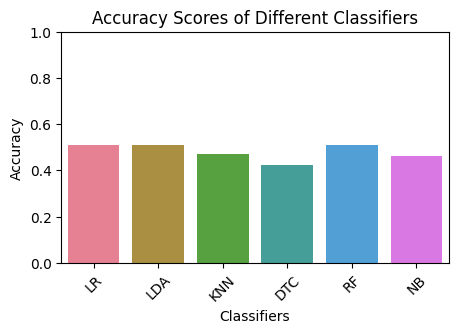

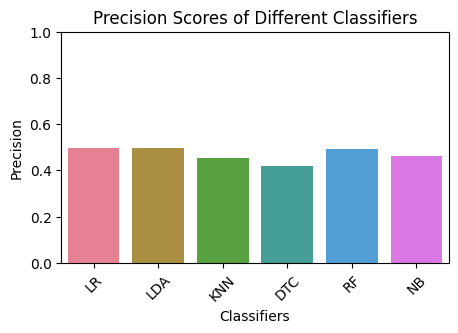

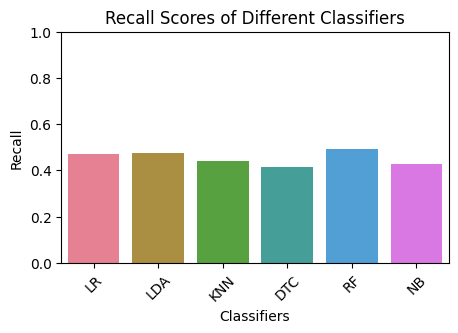

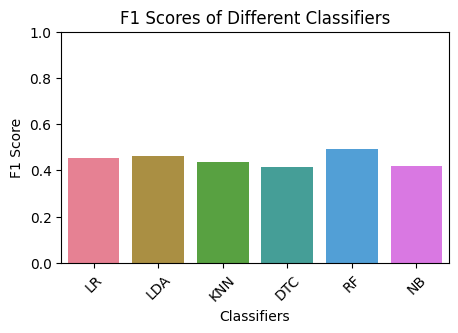

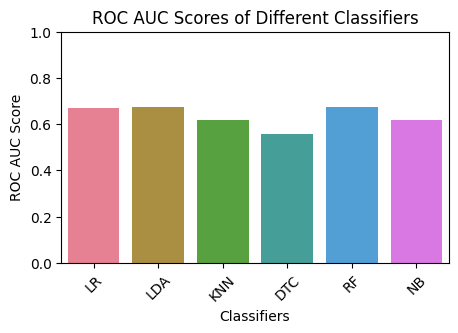

In [ ]:
# Plotting accuracies
plt.figure(figsize=(5, 3))
sns.barplot(x=classifiers, y=accuracies, palette='husl')
plt.title('Accuracy Scores of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plotting precisions
plt.figure(figsize=(5, 3))
sns.barplot(x=classifiers, y=precisions, palette='husl')
plt.title('Precision Scores of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plotting recalls
plt.figure(figsize=(5, 3))
sns.barplot(x=classifiers, y=recalls, palette='husl')
plt.title('Recall Scores of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Recall')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plotting F1 scores
plt.figure(figsize=(5, 3))
sns.barplot(x=classifiers, y=f1_scores, palette='husl')
plt.title('F1 Scores of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Plotting ROC AUC scores
plt.figure(figsize=(5, 3))
sns.barplot(x=classifiers, y=roc_auc_scores, palette='husl')
plt.title('ROC AUC Scores of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)  # Set y-axis limits
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [329]:
#| include: False
chatGPT = pd.read_excel('data/chatGPT.xlsx')
chatGPT.head()

,sentiment,comment
0,sadness,"Feeling blue today, everything seems gloomy."
1,happiness,"Grinning from ear to ear, life is beautiful!"
2,worry,"Anxiety kicking in, can't shake off these thou..."
3,neutral,"Feeling neither high nor low, just going with ..."
4,love,"Heart bursting with affection, surrounded by w..."


In [330]:
#  grouping 13 labels into 3 classes: 'negative', 'positive', 'neutral'
sentiment_mapping = {
    'empty': 'negative',
    'sadness': 'negative',
    'worry': 'negative',
    'hate': 'negative',
    'boredom': 'negative',
    'anger': 'negative',
    'enthusiasm': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'love': 'positive',
    'fun': 'positive',
    'happiness': 'positive',
    'relief': 'positive'
}

# Create a new col for the mapping
chatGPT['label'] = chatGPT['sentiment'].map(sentiment_mapping)

In [331]:
chatGPT.head()

,sentiment,comment,label
0,sadness,"Feeling blue today, everything seems gloomy.",negative
1,happiness,"Grinning from ear to ear, life is beautiful!",positive
2,worry,"Anxiety kicking in, can't shake off these thou...",negative
3,neutral,"Feeling neither high nor low, just going with ...",neutral
4,love,"Heart bursting with affection, surrounded by w...",positive


In [337]:
chatGPT['clean_content']=chatGPT['comment'].apply(text_cleaner)

In [338]:
chatGPT.head()

,sentiment,comment,label,clean_content
0,sadness,"Feeling blue today, everything seems gloomy.",negative,feel blue today everything gloomy
1,happiness,"Grinning from ear to ear, life is beautiful!",positive,grin ear ear life beautiful
2,worry,"Anxiety kicking in, can't shake off these thou...",negative,anxiety kick shake
3,neutral,"Feeling neither high nor low, just going with ...",neutral,feel neither high low go flow
4,love,"Heart bursting with affection, surrounded by w...",positive,heart affection surround warmth


In [335]:
print('The number of NaN-values in the pre-processed dataset is: ', chatGPT['clean_content'].isnull().sum())

The number of NaN-values in the pre-processed dataset is:  0


In [339]:
# Mapping sentiment num / encode
chatGPT["label_num"] = chatGPT.label.map({
    'negative': 0,
    'positive': 1,
    'neutral': 2
})

chatGPT = chatGPT.drop(columns=['label'])
chatGPT.head(5)

,sentiment,comment,clean_content,label_num
0,sadness,"Feeling blue today, everything seems gloomy.",feel blue today everything gloomy,0
1,happiness,"Grinning from ear to ear, life is beautiful!",grin ear ear life beautiful,1
2,worry,"Anxiety kicking in, can't shake off these thou...",anxiety kick shake,0
3,neutral,"Feeling neither high nor low, just going with ...",feel neither high low go flow,2
4,love,"Heart bursting with affection, surrounded by w...",heart affection surround warmth,1


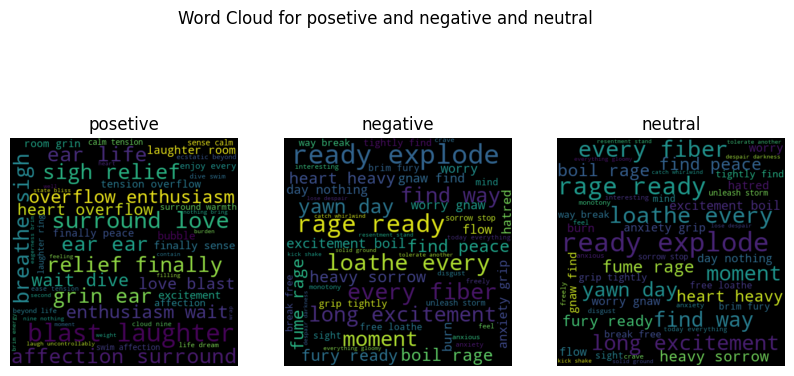

In [341]:
# Word Cloud

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))

posetive_text = ' '.join(chatGPT[chatGPT['label_num']==1]['clean_content'])
wordcloud_posetive = WordCloud(max_words=50, width=400, height=400).generate(posetive_text)

negative_text = ' '.join(chatGPT[chatGPT['label_num']==0]['clean_content'])
wordcloud_negative = WordCloud(max_words=50, width=400, height=400).generate(negative_text)

neutral_text = ' '.join(chatGPT[chatGPT['label_num']==0]['clean_content'])
wordcloud_neutral = WordCloud(max_words=50, width=400, height=400).generate(neutral_text)

ax1.imshow(wordcloud_posetive, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('posetive')

ax2.imshow(wordcloud_negative, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('negative')

ax3.imshow(wordcloud_neutral, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('neutral')
plt.suptitle('Word Cloud for posetive and negative and neutral');

In [342]:
tokenized_text = []
for i in chatGPT['clean_content']:
    x =  word_tokenize(i)
    tokenized_text.append(x)
chatGPT['tokenized'] = tokenized_text

In [344]:
chatGPT.head()

,sentiment,comment,clean_content,label_num,tokenized
0,sadness,"Feeling blue today, everything seems gloomy.",feel blue today everything gloomy,0,"[feel, blue, today, everything, gloomy]"
1,happiness,"Grinning from ear to ear, life is beautiful!",grin ear ear life beautiful,1,"[grin, ear, ear, life, beautiful]"
2,worry,"Anxiety kicking in, can't shake off these thou...",anxiety kick shake,0,"[anxiety, kick, shake]"
3,neutral,"Feeling neither high nor low, just going with ...",feel neither high low go flow,2,"[feel, neither, high, low, go, flow]"
4,love,"Heart bursting with affection, surrounded by w...",heart affection surround warmth,1,"[heart, affection, surround, warmth]"


In [349]:
le = LabelEncoder()
chatGPT['label_num'] = le.fit_transform(chatGPT['label_num'])
chatGPT.head()

,sentiment,comment,clean_content,label_num,tokenized
0,sadness,"Feeling blue today, everything seems gloomy.",feel blue today everything gloomy,0,"[feel, blue, today, everything, gloomy]"
1,happiness,"Grinning from ear to ear, life is beautiful!",grin ear ear life beautiful,1,"[grin, ear, ear, life, beautiful]"
2,worry,"Anxiety kicking in, can't shake off these thou...",anxiety kick shake,0,"[anxiety, kick, shake]"
3,neutral,"Feeling neither high nor low, just going with ...",feel neither high low go flow,2,"[feel, neither, high, low, go, flow]"
4,love,"Heart bursting with affection, surrounded by w...",heart affection surround warmth,1,"[heart, affection, surround, warmth]"


In [369]:
# Transforming the whole chatGPT texts into numerical vectors using word2vec models traind on the Blog Authorship Corpus Data

gptword2vec = pd.DataFrame(columns=['label_num'] + [f'vec{i}' for i in range(100)])

# Iterate over the rows of the original DataFrame
for index, row in chatGPT.iterrows():
    model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
    
    if type(model_vector) is list:  
        new_row = [row['label_num']] + model_vector
    else:
        new_row = [row['label_num']] + [0] * 100
        
    gptword2vec.loc[index] = new_row


C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountere

In [354]:
# Transforming the whole chatGPT texts into numerical vectors using word2vec models traind 

gptword2vec = pd.DataFrame(columns=['label_num'] + [f'vec{i}' for i in range(100)])

# Iterate over the rows of the original DataFrame
for index, row in chatGPT.iterrows():
    model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
    
    if type(model_vector) is list:  
        new_row = [row['label_num']] + model_vector
    else:
        new_row = [row['label_num']] + [0] * 100
        
    gptword2vec.loc[index] = new_row


C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountere

In [356]:
chatGPT.head()


,sentiment,comment,clean_content,label_num,tokenized
0,sadness,"Feeling blue today, everything seems gloomy.",feel blue today everything gloomy,0,"[feel, blue, today, everything, gloomy]"
1,happiness,"Grinning from ear to ear, life is beautiful!",grin ear ear life beautiful,1,"[grin, ear, ear, life, beautiful]"
2,worry,"Anxiety kicking in, can't shake off these thou...",anxiety kick shake,0,"[anxiety, kick, shake]"
3,neutral,"Feeling neither high nor low, just going with ...",feel neither high low go flow,2,"[feel, neither, high, low, go, flow]"
4,love,"Heart bursting with affection, surrounded by w...",heart affection surround warmth,1,"[heart, affection, surround, warmth]"


In [357]:
chatGPT.drop(['comment','clean_content','sentiment'],axis = 1, inplace = True)

In [360]:
chatGPT.head()

,label_num,tokenized
0,0,"[feel, blue, today, everything, gloomy]"
1,1,"[grin, ear, ear, life, beautiful]"
2,0,"[anxiety, kick, shake]"
3,2,"[feel, neither, high, low, go, flow]"
4,1,"[heart, affection, surround, warmth]"


In [370]:
# LSTM model trained on Data
X_gptword2vec = np.array(gptword2vec.drop('label_num', axis=1))
y_gptword2vec = np.array(gptword2vec['label_num'])

In [373]:
print(X_gptword2vec)

[[-0.04907529  0.09482428 -0.07899915 ... -0.24684818  0.0156074
  -0.04903707]
 [-0.01277967  0.10782614 -0.05721385 ... -0.23867276  0.0436199
  -0.04089211]
 [-0.005998    0.12672976  0.02273631 ... -0.24536867  0.02165975
   0.02269954]
 ...
 [ 0.02021165 -0.02321121 -0.06409127 ... -0.22255309 -0.03083475
  -0.18951221]
 [-0.05232801  0.15350673 -0.05381134 ... -0.17431474 -0.00180509
  -0.09176019]
 [-0.08453876  0.15843599 -0.05597355 ... -0.18161219  0.00737726
  -0.09946273]]


In [374]:
print(y_gptword2vec)

[0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2. 0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2.
 0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2. 0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2.
 0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2. 0. 1. 0. 2. 1. 0. 1. 1. 0. 1. 0. 2.
 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 1.
 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 1. 2. 0.
 2. 1. 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 0. 1. 2. 0. 2.
 1. 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1.
 0. 1. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 1. 0. 1. 0.]


In [377]:

# Evaluate the model
y_pred = model.predict(X_gptword2vec.reshape((-1, 100, 1)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


In [394]:
print(X_gptword2vec)

         vec0      vec1      vec2      vec3      vec4      vec5      vec6  \
0   -0.049075  0.094824 -0.078999 -0.116890 -0.037031 -0.280711  0.019000   
1   -0.012780  0.107826 -0.057214 -0.076043  0.096024 -0.237661  0.000224   
2   -0.005998  0.126730  0.022736 -0.015389  0.070731 -0.225750 -0.037126   
3   -0.069468  0.099667 -0.052265 -0.129696  0.045340 -0.211324  0.043861   
4    0.059823  0.060488  0.029393  0.021815  0.048922 -0.201699 -0.068183   
..        ...       ...       ...       ...       ...       ...       ...   
275 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742  0.004027   
276 -0.017181  0.138966 -0.011807 -0.060228  0.108139 -0.171211 -0.029964   
277  0.020212 -0.023211 -0.064091 -0.083460  0.145640 -0.298110  0.021982   
278 -0.052328  0.153507 -0.053811 -0.088312  0.136399 -0.186368 -0.079964   
279 -0.084539  0.158436 -0.055974 -0.114359  0.250540 -0.208638 -0.113372   

         vec7      vec8      vec9  ...     vec90     vec91     vec92  \
0  

In [378]:

# Calculate classification metrics
confusion = confusion_matrix(y_gptword2vec, np.argmax(y_pred, axis=1))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_gptword2vec, y_pred, average='weighted', multi_class='ovo')

# Calculate other classification metrics
precision = precision_score(y_gptword2vec, np.argmax(y_pred, axis=1), average='weighted')
f1 = f1_score(y_gptword2vec, np.argmax(y_pred, axis=1), average='weighted')
recall = recall_score(y_gptword2vec, np.argmax(y_pred, axis=1), average='weighted')

# Print classification metrics
print('Confusion Matrix:\n', confusion)
print('Precision: ', precision)
print('F1 Score: ', f1)
print('Recall: ', recall)
print('ROC AUC: ', roc_auc)


Confusion Matrix:
 [[78 31  3]
 [76 30 14]
 [22 26  0]]
Precision:  0.32505597850425433
F1 Score:  0.34089026915113874
Recall:  0.38571428571428573
ROC AUC:  0.49439147534013606


In [404]:
print(X_gptword2vec)

         vec0      vec1      vec2      vec3      vec4      vec5      vec6  \
0   -0.049075  0.094824 -0.078999 -0.116890 -0.037031 -0.280711  0.019000   
1   -0.012780  0.107826 -0.057214 -0.076043  0.096024 -0.237661  0.000224   
2   -0.005998  0.126730  0.022736 -0.015389  0.070731 -0.225750 -0.037126   
3   -0.069468  0.099667 -0.052265 -0.129696  0.045340 -0.211324  0.043861   
4    0.059823  0.060488  0.029393  0.021815  0.048922 -0.201699 -0.068183   
..        ...       ...       ...       ...       ...       ...       ...   
275 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742  0.004027   
276 -0.017181  0.138966 -0.011807 -0.060228  0.108139 -0.171211 -0.029964   
277  0.020212 -0.023211 -0.064091 -0.083460  0.145640 -0.298110  0.021982   
278 -0.052328  0.153507 -0.053811 -0.088312  0.136399 -0.186368 -0.079964   
279 -0.084539  0.158436 -0.055974 -0.114359  0.250540 -0.208638 -0.113372   

         vec7      vec8      vec9  ...     vec90     vec91     vec92  \
0  

In [405]:
# Generate column names ['0', '1', '2', ..., '99']
column_names = [str(i) for i in range(100)]

# Assign column names to X_gptword2vec
X_gptword2vec.columns = column_names
print(X_gptword2vec)

            0         1         2         3         4         5         6  \
0   -0.049075  0.094824 -0.078999 -0.116890 -0.037031 -0.280711  0.019000   
1   -0.012780  0.107826 -0.057214 -0.076043  0.096024 -0.237661  0.000224   
2   -0.005998  0.126730  0.022736 -0.015389  0.070731 -0.225750 -0.037126   
3   -0.069468  0.099667 -0.052265 -0.129696  0.045340 -0.211324  0.043861   
4    0.059823  0.060488  0.029393  0.021815  0.048922 -0.201699 -0.068183   
..        ...       ...       ...       ...       ...       ...       ...   
275 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742  0.004027   
276 -0.017181  0.138966 -0.011807 -0.060228  0.108139 -0.171211 -0.029964   
277  0.020212 -0.023211 -0.064091 -0.083460  0.145640 -0.298110  0.021982   
278 -0.052328  0.153507 -0.053811 -0.088312  0.136399 -0.186368 -0.079964   
279 -0.084539  0.158436 -0.055974 -0.114359  0.250540 -0.208638 -0.113372   

            7         8         9  ...        90        91        92  \
0  

In [421]:


models = []
models.append(('LR', LogisticRegression(n_jobs=-1, C=10)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 12, criterion= 'entropy',
                                            bootstrap= True, class_weight='balanced')))
models.append(('NB', GaussianNB()))



In [422]:
print('Classified chantGPT text using the trained algorithms on Blog Authorship Corpus Data')
print()
# Generate column names ['0', '1', '2', ..., '99']
column_names = [str(i) for i in range(100)]
# Assign column names to X_gptword2vec
X_gptword2vec.columns = column_names

for name, model in models:
    model.fit(xtrain, ytrain)
    gptypred = model.predict(X_gptword2vec)

    accuracy = accuracy_score(y_gptword2vec, gptypred) 
    precision = precision_score(y_gptword2vec, gptypred, average='macro')
    recall = recall_score(y_gptword2vec, gptypred, average='macro') 
    f1 = f1_score(y_gptword2vec, gptypred, average='macro') 
        # Calculate ROC AUC score
    if len(np.unique(ytest)) > 2:
        y_prob = model.predict_proba(xtest)  # Use predict_proba to get probability estimates
        roc_auc = roc_auc_score(ytest, y_prob, average='macro', multi_class='ovo')
    else:
        roc_auc = roc_auc_score(ytest, ypred, average='macro', multi_class='ovr')
         
    print('Classifier:', name)
    print('Accuracy: %.2f' % accuracy)
    print('Precision: %.2f' % precision)
    print('Recall: %.2f' % recall)
    print('F1 Score: %.2f' % f1)
    print('ROC AUC:%.2f' % roc_auc)
    print()


Classified chantGPT text using the trained algorithms on Blog Authorship Corpus Data

Classifier: LR
Accuracy: 0.42
Precision: 0.28
Recall: 0.35
F1 Score: 0.30
ROC AUC:0.67

Classifier: LDA
Accuracy: 0.41
Precision: 0.30
Recall: 0.34
F1 Score: 0.30
ROC AUC:0.67

Classifier: KNN
Accuracy: 0.40
Precision: 0.36
Recall: 0.34
F1 Score: 0.34
ROC AUC:0.62

Classifier: DTC
Accuracy: 0.36
Precision: 0.34
Recall: 0.33
F1 Score: 0.33
ROC AUC:0.56

Classifier: RF
Accuracy: 0.38
Precision: 0.37
Recall: 0.36
F1 Score: 0.36
ROC AUC:0.67

Classifier: NB
Accuracy: 0.31
Precision: 0.23
Recall: 0.26
F1 Score: 0.23
ROC AUC:0.62



In [472]:
# Splitting chatSPT texts into test and train datasets

chatGPTtrain, chatGPTtest = train_test_split(chatGPT, test_size=0.2, random_state = 18)

chatGPTxtrain = chatGPTtrain['tokenized'].reset_index()
chatGPTytrain = chatGPTtrain['label_num']
chatGPTxtest = chatGPTtest['tokenized'].reset_index()
chatGPTytest = chatGPTtest['label_num']
print('xtrain shape: ',chatGPTxtrain.shape)
print('ytrain shape: ',chatGPTytrain.shape)
print('xtest shape: ',chatGPTxtest.shape)
print('ytest shape: ',chatGPTytest.shape)

xtrain shape:  (224, 2)
ytrain shape:  (224,)
xtest shape:  (56, 2)
ytest shape:  (56,)


In [473]:
# Transforming the train dataset of chatGPT texts into numerical vectors using word2vec models traind on the Blog Authorship Corpus Data

gptword2vectrain = pd.DataFrame(columns=['label_num'] + [f'vec{i}' for i in range(100)])

for index, row in chatGPTtrain.iterrows():
    model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
    
    if type(model_vector) is list:  
        new_row = [row['label_num']] + model_vector
    else:
        new_row = [row['label_num']] + [0] * 100
        
    gptword2vectrain.loc[index] = new_row


C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nastaran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountere

In [474]:
# Transforming the test dataset of chatGPT texts into numerical vectors using word2vec models traind on the Blog Authorship Corpus Data

gptword2vectest = pd.DataFrame(columns=['label_num'] + [f'vec{i}' for i in range(100)])

for index, row in chatGPTtest.iterrows():
    model_vector = (np.mean([w2v_model.wv[token] for token in row['tokenized'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
    
    if type(model_vector) is list:  
        new_row = [row['label_num']] + model_vector
    else:
        new_row = [row['label_num']] + [0] * 100
        
    gptword2vectest.loc[index] = new_row

In [475]:
print(gptword2vectest)

     label_num      vec0      vec1      vec2      vec3      vec4      vec5  \
91         0.0 -0.002860  0.117373 -0.061566 -0.031123  0.067099 -0.268352   
143        1.0  0.060055  0.355773 -0.269752  0.211155  0.430648 -0.022589   
95         0.0 -0.084326  0.122055 -0.056866 -0.100075  0.154534 -0.227827   
231        1.0 -0.011791  0.132275 -0.004068 -0.050339  0.067029 -0.208318   
57         1.0  0.060055  0.355773 -0.269752  0.211155  0.430648 -0.022589   
127        0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   
149        0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   
123        0.0  0.014541  0.180417  0.045541 -0.010693  0.082870 -0.202190   
194        0.0 -0.031378  0.137333 -0.019637 -0.046238  0.056190 -0.205694   
126        1.0 -0.036434  0.117819 -0.078786 -0.066997  0.075012 -0.232366   
211        0.0  0.102709  0.131638  0.129951 -0.127866  0.079226 -0.157821   
6          1.0 -0.037235  0.035912 -0.048605 -0.055415  0.053154

In [477]:
# Generate column names ['0', '1', '2', ..., '99']
column_names = [str(i) for i in range(101)]
# Assign column names to X_gptword2vec
gptword2vectest.columns = column_names


In [478]:
print(gptword2vectest)

       0         1         2         3         4         5         6  \
91   0.0 -0.002860  0.117373 -0.061566 -0.031123  0.067099 -0.268352   
143  1.0  0.060055  0.355773 -0.269752  0.211155  0.430648 -0.022589   
95   0.0 -0.084326  0.122055 -0.056866 -0.100075  0.154534 -0.227827   
231  1.0 -0.011791  0.132275 -0.004068 -0.050339  0.067029 -0.208318   
57   1.0  0.060055  0.355773 -0.269752  0.211155  0.430648 -0.022589   
127  0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   
149  0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   
123  0.0  0.014541  0.180417  0.045541 -0.010693  0.082870 -0.202190   
194  0.0 -0.031378  0.137333 -0.019637 -0.046238  0.056190 -0.205694   
126  1.0 -0.036434  0.117819 -0.078786 -0.066997  0.075012 -0.232366   
211  0.0  0.102709  0.131638  0.129951 -0.127866  0.079226 -0.157821   
6    1.0 -0.037235  0.035912 -0.048605 -0.055415  0.053154 -0.333198   
41   0.0 -0.014458  0.156513  0.004242 -0.028389  0.096328 -0.17

In [480]:
# Generate column names ['0', '1', '2', ..., '99']
column_names = [str(i) for i in range(101)]
# Assign column names to X_gptword2vec
gptword2vectrain.columns = column_names


In [481]:
print(gptword2vectrain)

       0         1         2         3         4         5         6  \
203  2.0  0.003846  0.139539 -0.029682 -0.103750  0.115152 -0.222276   
24   0.0  0.102709  0.131638  0.129951 -0.127866  0.079226 -0.157821   
196  0.0  0.039278  0.126261 -0.125885 -0.119508  0.127556 -0.236233   
33   1.0 -0.001033  0.136269 -0.030023 -0.076045  0.236117 -0.167348   
229  1.0 -0.003735  0.101274 -0.018582 -0.011544  0.087729 -0.217473   
..   ...       ...       ...       ...       ...       ...       ...   
242  0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   
174  1.0 -0.052964  0.173223 -0.007854 -0.069203  0.155886 -0.175089   
190  0.0 -0.005998  0.126730  0.022736 -0.015389  0.070731 -0.225750   
120  0.0  0.046757  0.292081  0.071044 -0.039835  0.054226 -0.126448   
275  0.0 -0.038425  0.008889 -0.120281 -0.021217  0.163284 -0.448742   

            7         8         9  ...        91        92        93  \
203 -0.023382  0.386107 -0.202212  ...  0.150665  0.179317  0.0

In [482]:
# LSTM model traind on chatGPT data
X_train = np.array(gptword2vectrain.drop('0', axis=1))
y_train = np.array(gptword2vectrain['0'])
X_test = np.array(gptword2vectest.drop('0', axis=1))
y_test = np.array(gptword2vectest['0'])

In [485]:
# Define the input shape
input_shape = (X_train.shape[1], 1)

# Define the LSTM model
inputs = Input(shape=input_shape)
lstm = LSTM(128)(inputs)
outputs = Dense(3, activation='softmax')(lstm)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train.reshape((-1, *input_shape)), y_train, batch_size=32, epochs=10, validation_data=(X_test.reshape((-1, *input_shape)), y_test))

# Evaluate the model
y_pred = model.predict(X_test.reshape((-1, *input_shape)))

# Calculate evaluation metrics
confusion = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
f1 = f1_score(y_test, np.argmax(y_pred, axis=1), average='weighted')  # Specify average for multiclass problems
recall = recall_score(y_test, np.argmax(y_pred, axis=1), average='weighted')  # Specify average for multiclass problems
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')  # Specify multi_class for multiclass problems

# Print classification metrics
print('Confusion Matrix:\n', confusion)
print('Accuracy: ', acc)
print('F1 Score: ', f1)
print('Recall: ', recall)
print('ROC AUC: ', roc_auc)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 671ms/step - accuracy: 0.3532 - loss: 1.0946 - val_accuracy: 0.3750 - val_loss: 1.0636
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.4660 - loss: 1.0672 - val_accuracy: 0.3750 - val_loss: 1.0135
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.4452 - loss: 1.0617 - val_accuracy: 0.3750 - val_loss: 1.0436
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.4755 - loss: 1.0578 - val_accuracy: 0.3750 - val_loss: 1.0422
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.4424 - loss: 1.0533 - val_accuracy: 0.3750 - val_loss: 1.0304
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.4522 - loss: 1.0448 - val_accuracy: 0.3750 - val_loss: 1.0155
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4068 - loss: 1.0521 - val_accuracy: 0.3750 - val_loss: 1.0033
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.4100 - loss: 1.0542 - val_accuracy: 0.3750 - val_loss

In [486]:


print('Classification Algorithms on Data')
print()

gptxtrain = gptword2vectrain.iloc[:,1:]
gptxtest = gptword2vectest.iloc[:,1:]
gptytrain = gptword2vectrain['0']
gptytest = gptword2vectest['0']

for name, model in models:
    if isinstance(model, RandomForestClassifier):
        model.set_params(max_features='sqrt')  # Adjust the max_features parameter
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    accuracy = accuracy_score(ytest, ypred) 
    precision = precision_score(ytest, ypred, average='macro')
    recall = recall_score(ytest, ypred, average='macro')
    f1 = f1_score(ytest, ypred, average='macro')
    
    # Calculate ROC AUC score
    if len(np.unique(ytest)) > 2:
        y_prob = model.predict_proba(xtest)  # Use predict_proba to get probability estimates
        roc_auc = roc_auc_score(ytest, y_prob, average='macro', multi_class='ovo')
    else:
        roc_auc = roc_auc_score(ytest, ypred, average='macro', multi_class='ovr')
    
    print('Classifier:', name)
    print('Accuracy: %.2f' % accuracy)
    print('Precision: %.2f' % precision)
    print('Recall: %.2f' % recall)
    print('F1 Score: %.2f' % f1)
    print('ROC AUC:%.2f' % roc_auc)
    print()


Classification Algorithms on Data

Classifier: LR
Accuracy: 0.51
Precision: 0.50
Recall: 0.47
F1 Score: 0.46
ROC AUC:0.67

Classifier: LDA
Accuracy: 0.52
Precision: 0.51
Recall: 0.48
F1 Score: 0.47
ROC AUC:0.67

Classifier: KNN
Accuracy: 0.47
Precision: 0.45
Recall: 0.44
F1 Score: 0.43
ROC AUC:0.62

Classifier: DTC
Accuracy: 0.43
Precision: 0.42
Recall: 0.42
F1 Score: 0.42
ROC AUC:0.56

Classifier: RF
Accuracy: 0.51
Precision: 0.49
Recall: 0.49
F1 Score: 0.49
ROC AUC:0.68

Classifier: NB
Accuracy: 0.46
Precision: 0.46
Recall: 0.43
F1 Score: 0.42
ROC AUC:0.62

